In [1]:
#Imports all the necessary Python Libraries facilitating the Instance Segmentation

import os
#from elf.io import open_file
from glob import glob
import tifffile as tiff
import numpy as np
#import h5py
from skimage.measure import label as connected_components
import imageio.v3 as imageio
import napari

#import zarr
#from zarr.storage import KVStore

from torch_em.util.util import get_random_colors

from micro_sam import util
from micro_sam.evaluation.model_comparison import _enhance_image
from micro_sam.instance_segmentation import(
    InstanceSegmentationWithDecoder,
    AutomaticMaskGenerator,
    get_predictor_and_decoder,
    mask_data_to_segmentation
)


from micro_sam.sam_annotator import annotator_3d
from micro_sam import instance_segmentation, util
from micro_sam.multi_dimensional_segmentation import automatic_3d_segmentation
#from micro_sam.util import get_cache_directory

c:\Users\Adam\miniforge3\envs\GPU-micro-sam\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#https://github.com/computational-cell-analytics/micro-sam/blob/master/examples/use_as_library/instance_segmentation.py
def annotator(file, index):
    # Uses the Light Microscopy Model specialised in Cells & Nuclei
    model = "vit_l_lm"
    #Where the Image embeddings are stored
    embeddingPath = f"./trialRUN2{index}.zarr"

    predictor, decoder = instance_segmentation.get_predictor_and_decoder(model, checkpoint_path=None)
    segmentor = instance_segmentation.InstanceSegmentationWithDecoder(predictor,decoder)
    
    #Annotates the file using Micro-Sam's Automatic 3D Segmentation tool
    results = automatic_3d_segmentation(file, predictor, segmentor, embeddingPath, gap_closing=2, min_object_size=50, center_distance_threshold=0.5, verbose=True, with_background=True)
    # Opens the results in Napari
    #v=napari.Viewer()
    #v.add_image(file)
    #v.add_labels(results)
    #napari.run()
    return results

In [3]:
#https://www.geeksforgeeks.org/python-os-path-abspath-method-with-example/
#https://www.earthdatascience.org/courses/intro-to-earth-data-science/python-code-fundamentals/work-with-files-directories-paths-in-python/os-glob-manipulate-file-paths/
# Extracts all the file paths within the Microscopy_Images folder
def fileExtract():
    folderPath = os.path.abspath("Microscopy_Images")
    print(folderPath)
    filePaths = sorted(glob(os.path.join(folderPath,"*")))
    print(filePaths)
    return filePaths

In [4]:
#https://pypi.org/project/tifffile/
##https://www.geeksforgeeks.org/python-os-path-abspath-method-with-example/
#https://www.geeksforgeeks.org/formatted-string-literals-f-strings-python/
#https://www.geeksforgeeks.org/python-os-path-join-method/
def readFiles(filePaths):
    #Gets the folder path of where all the results are then stored
    folder = os.path.abspath("3D_Results")
    index=0
    for file in filePaths:
        #Reads the Tiff File
        tiffFile = tiff.imread(file)
        #The Tiff File is then annotated
        chResult = annotator(tiffFile,index)
        #The name of the file the results are stored in
        fileName = f"C1RHOTrial2-Results{index}.tif"
        # Where the file is exported to
        storePath = os.path.join(folder,fileName)
        tiff.imwrite(storePath, chResult, photometric='rgb')
        index=index+1

In [5]:
def runProgram():
    filePaths = fileExtract()
    print("Files Extracted")
    readFiles(filePaths)
    


In [6]:
runProgram()

c:\Users\Adam\OneDrive\Internship_2024\3D_Auto_Segmentation\Microscopy_Images
['c:\\Users\\Adam\\OneDrive\\Internship_2024\\3D_Auto_Segmentation\\Microscopy_Images\\C1-RhoPhalYw.lif - Series030.tif']
Files Extracted


Merge segmentation: 100%|██████████| 55/55 [00:10<00:00,  5.44it/s]


# Displaying Annotations & Segmentations

In [1]:
#Example Files
def exampleData():
    folderPath = os.path.abspath("3D_Results")
    ch1File = "Series-80Results0.tif"
    ch2File = "Series-80Results1.tif"
    ch3File = "Series-80Results2.tif"
    ch4File = "Series-80Results3.tif"
    filePath1 = os.path.join(folderPath, ch1File)
    filePath2 = os.path.join(folderPath, ch2File)
    filePath3 = os.path.join(folderPath, ch3File)
    filePath4 = os.path.join(folderPath, ch4File)
    ch1 = tiff.imread(filePath1)
    ch2 = tiff.imread(filePath2)
    ch3 = tiff.imread(filePath3)
    ch4 = tiff.imread(filePath4)
    return ch1, ch2, ch3, ch4

In [3]:
import matplotlib.pyplot as plt
ch1, ch2, ch3, ch4 = exampleData()

Text(0.5, 1.0, 'Channel 4')

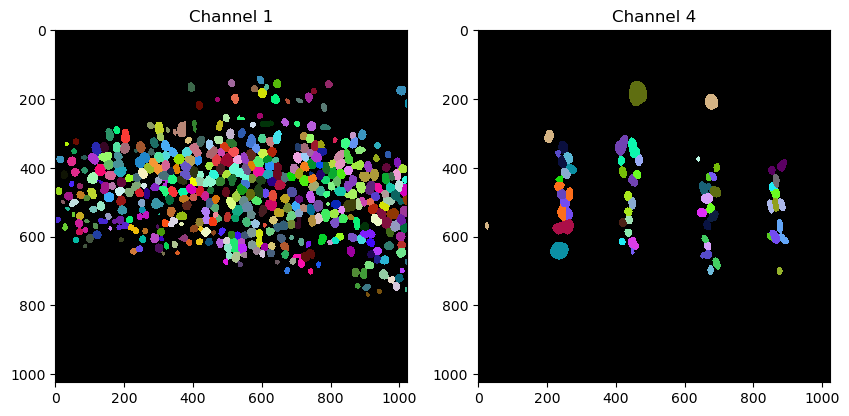

In [5]:
fig, ax = plt.subplots(1,2, figsize=(10,10))
ax[0].imshow(ch1[30], cmap=get_random_colors(ch1[30]),interpolation="nearest")
ax[0].set_title("Channel 1")
ax[1].imshow(ch4[30], cmap=get_random_colors(ch4[30]),interpolation="nearest")
ax[1].set_title("Channel 4")    


Text(0.5, 1.0, 'Channel 3')

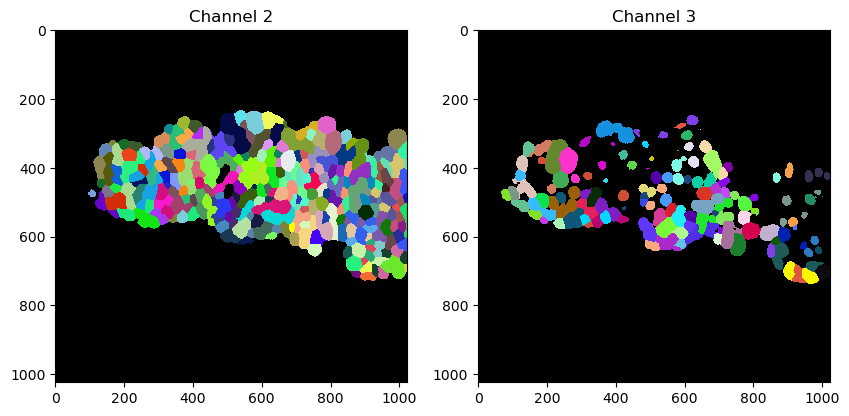

In [6]:
fig, ax = plt.subplots(1,2, figsize=(10,10))
ax[0].imshow(ch2[10], cmap=get_random_colors(ch2[10]),interpolation="nearest")
ax[0].set_title("Channel 2")
ax[1].imshow(ch3[10], cmap=get_random_colors(ch3[10]),interpolation="nearest")
ax[1].set_title("Channel 3")

# Centroid Calculation

In [17]:
#https://www.geeksforgeeks.org/python-pil-imagedraw-draw-text/
#https://www.geeksforgeeks.org/python-pil-imagedraw-draw-ellipse/
def calculateCentroid(annotations):
    #https://docs.scipy.org/doc/scipy/reference/generated/scipy.ndimage.center_of_mass.html
    #https://docs.scipy.org/doc/scipy-0.10.1/reference/generated/scipy.ndimage.measurements.center_of_mass.html
    #https://numpy.org/doc/stable/reference/generated/numpy.unique.html
    from scipy.ndimage import center_of_mass
    #Used to store all the center points
    print("Now calculating the Centroids of the annotations")
    centerPoints = {}
    allCentroids = {}
    #This iterates through each frame annotation and i is used to determine the frame number
    for i, frame in enumerate(annotations):
        #Grab all the unique labels for that specific frame
        cellLabels = np.unique(frame)
        # For each label, if the center point is calculated as long as it is not equal to zero
        for centerPoint in cellLabels:
            if centerPoint == 0:
                continue
            point = center_of_mass(frame,labels=frame, index=centerPoint)
            # The center point is than appended to the dictionary
            centerPoints[centerPoint] = point
        # Storing all the centroids for each frame
        allCentroids[i]=centerPoints

    return allCentroids

In [21]:
# Calculate the centroid for the file located in the folder CentroidCalculate
centroidPath = os.path.abspath("CentroidCalculate")
filePaths = sorted(glob(os.path.join(centroidPath,"*")))
for file in filePaths:
    annotations = tiff.imread(file)
    centroids = calculateCentroid(annotations)

Now calculating the Centroids of the annotations


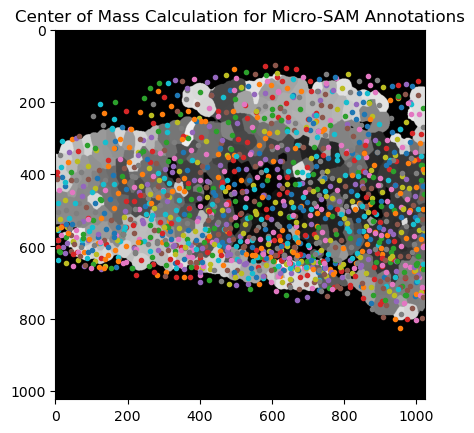

In [26]:
#https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.plot.html
#Displays the frame annotations selected in grayscale
plt.imshow(annotations[32], cmap='gray')
#https://www.w3schools.com/python/ref_dictionary_items.asp
# For each label the x and y co-ordinates are grabbed and plotted as dots
# This is then displayed below
for labels, (y,x) in centroids[32].items():
    plt.plot(x,y, '.')
plt.title("Center of Mass Calculation for Micro-SAM Annotations")
plt.show()

# Trial Code

In [2]:
def maskGenerator(file):
    print(file.shape)
    model = "vit_l_lm"
    predictor = util.get_sam_model(model_type=model)
    embeddings = util.precompute_image_embeddings(predictor, file, ndim=3)
    amg = AutomaticMaskGenerator(predictor)
    amg.initialize(image=file, image_embeddings=embeddings)
    prediction = amg.generate(pred_iou_thresh=0.75, stability_score_thresh=0.75)

    result = mask_data_to_segmentation(prediction, with_background=True)
    v=napari.Viewer()
    v.add_image(file)
    v.add_labels(prediction)
    v.add_labels(result)
    napari.run()

In [3]:
def readFileMask(filePath):
    folder = os.path.abspath("3D_Results")
    index=0
    for file in filePath:
        tiffFile = tiff.imread(file)
        print(tiffFile.shape)
        print("Embeddings Next")
        chResult = maskGenerator(tiffFile)
        #results.append(chResult)
        fileName = f"TrialResults{index}.tif"
        storePath = os.path.join(folder,fileName)
        tiff.imwrite(storePath, chResult, photometric='rgb')
        index=index+1

In [8]:
def runMaskGen():
    filePath = fileExtract()
    readFileMask(filePath)

runMaskGen()

(29, 1024, 1024)
Embeddings Next
(29, 1024, 1024)


Compute Image Embeddings 3D: 100%|██████████| 29/29 [00:20<00:00,  1.38it/s]


ValueError: The data is 3D so an index i is needed.

In [ ]:
#This allows you to manually annotate the tiff file
# This is not automated like the above one
def annotator3D(file, index):
     model = "vit_l_lm"
     embeddingPath = f"./TrialFile{index}.zarr"
     amg_State=True
     #embeddings = util.precompute_image_embeddings(predictor=predictor, input_=file,ndim=3)
     annotator_3d(file, embedding_path=embeddingPath, model_type=model, precompute_amg_state=amg_State)
     